In [109]:
from itertools import groupby
from operator import itemgetter

import pandas as pd
import pickle
from sklearn.decomposition import PCA
import sparse

import sktensor
#from tensorly import decomposition
from cp_orth import orth_als

import logging
logging.basicConfig(
    format="%(asctime)s %(module)s (%(lineno)s) %(levelname)s %(message)s",
    level=logging.DEBUG)

from matplotlib import pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)

Populating the interactive namespace from numpy and matplotlib


/home/makrai/tool/python/venv3/lib/python3.4/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rank', 'scatter']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
names = ['verb', 'args', 'mazsola1', 'mazsola_.5m', 'tade', 'prev', 'prev_inf', 'MetaMorpho', 
         'sum_rel_freq']
manocska = pd.read_csv('/home/makrai/repo/manocska/manocska.sorted.txt', sep='\t', names=names, index_col=[0,1], 
                       na_values='None')

1. verb lemma (the verbal particle is separated by pipe, |)
2. arguments, separated by space
3. frequency based on the Hungarian verbal structures (dictionary)
4. frequency based on the 500000 verbal structures (list)
5. frequency based on Tádé
6. frequency based on Ágnes Kalivoda's MA thesis (in the case no particle, this field in None)
7. frequency based on Ágnes Kalivoda's collection _Infinitival constructions in Hungarian_; 
    in case of no infinitival argument, this field is None
8. frequency based on MetaMorpho
9. sum of the relative frequencies of the freame in each resource

In [3]:
manocska = manocska.fillna(0)

In [14]:
manocska.head()

,,mazsola1,mazsola_.5m,tade,prev,prev_inf,MetaMorpho,sum_rel_freq
verb,args,,,,,,,
kell,INF,0,0,365197,0.0,1512519.0,0,0.219617
tud,INF,0,0,85760,0.0,1388057.0,0,0.173420
lehet,INF,0,0,110822,0.0,1139548.0,0,0.146930
fog,INF,0,0,47494,0.0,840888.0,0,0.104555
akar,INF,0,0,27731,0.0,612623.0,0,0.075398


# Visualization
## Only Mazsola (two versions) and Tádé

In [35]:
def scatter(mncs3):
    plt.scatter(mncs3[:,0], mncs3[:,1], c=mncs3[:,2], s=.1)

2018-10-09 14:15:01,113 <ipython-input-15-13dca88ad470> (3) INFO [[ 0.15664163  0.97740439  0.1419298 ]
 [ 0.1960217  -0.17161125  0.96546625]
 [ 0.96800769 -0.12341088 -0.21847394]]


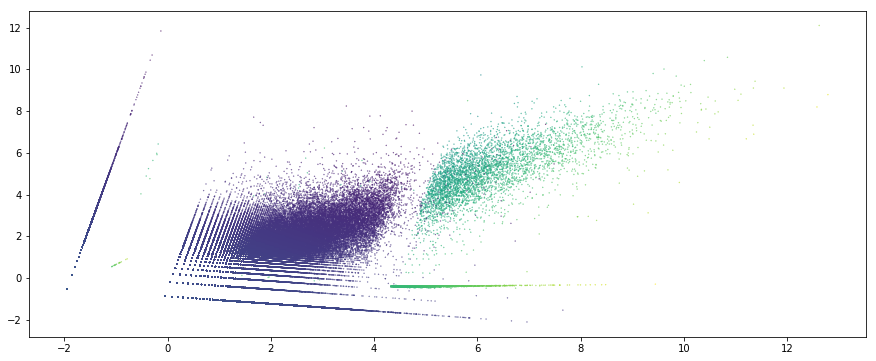

In [15]:
pca = PCA(n_components=3)
mncs3 = pca.fit_transform(np.log(manocska.values[:500000,:3] + 1))#[['mazsola1', 'mazsola_.5m', 'tade']])
logging.info(pca.components_)
plt.scatter(mncs3)

## All resources (but not `rank`)

2018-10-09 14:15:15,364 <ipython-input-16-5e0ad60185b9> (3) INFO [[ 0.01760699  0.16695943  0.04376072 -0.98479263  0.00137555  0.00900681]
 [ 0.16320183  0.96660844  0.09828583  0.17112256 -0.00904067 -0.0029176 ]
 [ 0.20670389 -0.13736736  0.96819149  0.02361058  0.01118295  0.01806755]]


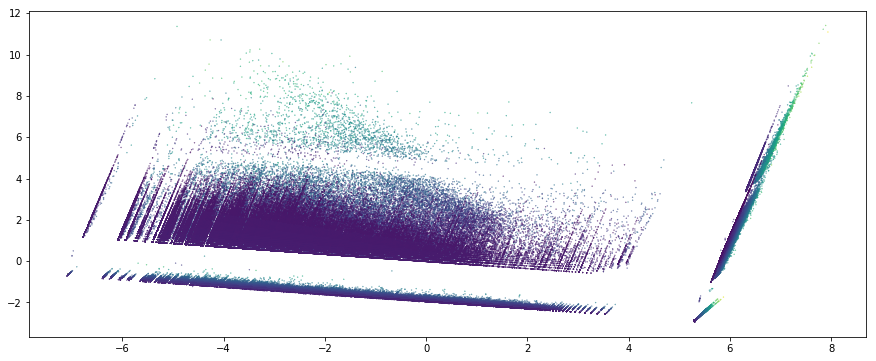

In [16]:
pca = PCA(n_components=3)
mncs3 = pca.fit_transform(np.log(manocska.values[:500000,:-1] + 1))#[['mazsola1', 'mazsola_.5m', 'tade']])
logging.info('\n{}'.format(pca.components_))
scatter(mncs3)

# Towards a preverb--verb--case tensor

In [85]:
prevs, verbs = zip(*[verb.split('|') for verb, frame in manocska.index if '|' in verb])
cases = [case for verb, frame in manocska.index for case in frame.split(' ')]

In [86]:
def marginal(prevs):
    ans = sorted([(key, len(list(group))) for key, group in groupby(sorted(prevs))], 
                  key=itemgetter(1), reverse=True)
    print(ans[:6])
    return dict(ans), {w: i for (i, (w, freq)) in enumerate(ans)}

In [87]:
freqs, dicts = zip(*[marginal(list_) for list_ in [prevs, verbs, cases]])

[('meg', 91070), ('el', 60531), ('ki', 48548), ('be', 32611), ('fel', 31793), ('le', 21611)]
[('ad', 6561), ('vesz', 5041), ('tesz', 4734), ('mond', 3917), ('megy', 3717), ('ír', 3672)]
[('[Acc]', 362663), ('[Ine]', 140067), ('[Ins]', 97720), ('[Supe]', 96529), ('[Dat]', 96330), ('[Subl]', 94479)]


In [105]:
def get_tensor(resource='mazsola1', middle_end='sktensor', add_smooth=1):
    coords, data = [[], [], []], []
    for i, ((verb, frame), row) in enumerate(manocska.iterrows()):
        if not i % 100000:
            logging.info('{} {} {}'.format(i, verb, frame))
        try:
            prev, verb = verb.split('|')
        except:
            continue
        val = np.log(row[resource] + add_smooth)
        for case in frame.split(' '):
            marg_prev_verb = np.log(freqs[0][prev]) + np.log(freqs[1][verb])
            for i, item in enumerate([prev, verb, case]):
                coords[i].append(dicts[i][item])
                if add_smooth:
                    val -= marg_prev_verb + np.log(freqs[2][case])
            data.append(val)
    shape = tuple(map(len, marginals))
    logging.debug(([len(mode) for mode in coords], len(data)))
    if middle_end == 'tensorly':
        tensor = sparse.COO(coords, data, shape=shape)#, has_duplicates=False)
    elif middle_end == 'sktensor':
        tensor = sktensor.sptensor(tuple(coords), data, shape=shape)
    logging.info(tensor)
    return tensor

In [106]:
tensor = get_tensor()

2018-10-09 15:05:47,048 <ipython-input-105-7691a06d4025> (5) INFO 0 kell INF
2018-10-09 15:05:51,980 <ipython-input-105-7691a06d4025> (5) INFO 100000 fenn|áll =alapján [Temp]
2018-10-09 15:05:57,224 <ipython-input-105-7691a06d4025> (5) INFO 200000 el|terel [Supe] forgalom[Acc]
2018-10-09 15:06:00,975 <ipython-input-105-7691a06d4025> (5) INFO 300000 el|hangzik =előtt [Supe]
2018-10-09 15:06:05,174 <ipython-input-105-7691a06d4025> (5) INFO 400000 el|tör váll[Poss][Nom]
2018-10-09 15:06:07,048 <ipython-input-105-7691a06d4025> (5) INFO 500000 rúg százalékár[Poss][Nom]
2018-10-09 15:06:08,468 <ipython-input-105-7691a06d4025> (5) INFO 600000 kifogásol [Acc] [Ill]
2018-10-09 15:06:09,796 <ipython-input-105-7691a06d4025> (5) INFO 700000 követ árnyék[Poss][Nom]
2018-10-09 15:06:11,104 <ipython-input-105-7691a06d4025> (5) INFO 800000 keres =óta [Acc] [Dat]
2018-10-09 15:06:12,530 <ipython-input-105-7691a06d4025> (5) INFO 900000 lehet =felé [All]
2018-10-09 15:06:13,607 <ipython-input-105-7691a06

In [107]:
rank = 3

In [108]:
ktensor, fit, itr, exectimes = orth_als(tensor, rank)

2018-10-09 15:06:18,530 cp_orth (215) DEBUG [  0] fit: 28.34290 | delta: 2.8e+01 | secs: 3.39143
2018-10-09 15:06:18,531 cp_orth (188) DEBUG Zero norm, mode 0, count 0
2018-10-09 15:06:18,532 cp_orth (188) DEBUG Zero norm, mode 1, count 0
2018-10-09 15:06:18,538 cp_orth (188) DEBUG Zero norm, mode 2, count 1
2018-10-09 15:06:20,497 cp_orth (215) DEBUG [  1] fit: 30.80909 | delta: 2.5e+00 | secs: 2.87823
2018-10-09 15:06:20,498 cp_orth (188) DEBUG Zero norm, mode 0, count 0
2018-10-09 15:06:20,499 cp_orth (188) DEBUG Zero norm, mode 1, count 0
2018-10-09 15:06:20,504 cp_orth (188) DEBUG Zero norm, mode 2, count 1
2018-10-09 15:06:22,463 cp_orth (215) DEBUG [  2] fit: 34.33045 | delta: 3.5e+00 | secs: 2.84458
2018-10-09 15:06:22,477 cp_orth (188) DEBUG Zero norm, mode 0, count 0
2018-10-09 15:06:22,478 cp_orth (188) DEBUG Zero norm, mode 1, count 0
2018-10-09 15:06:22,482 cp_orth (188) DEBUG Zero norm, mode 2, count 1
2018-10-09 15:06:24,432 cp_orth (215) DEBUG [  3] fit: 39.17457 | delt

2018-10-09 15:09:05,171 cp_orth (215) DEBUG [ 76] fit: 46.85367 | delta: 1.5e-03 | secs: 2.44537
2018-10-09 15:09:07,851 cp_orth (215) DEBUG [ 77] fit: 46.85512 | delta: 1.5e-03 | secs: 3.14033
2018-10-09 15:09:10,620 cp_orth (215) DEBUG [ 78] fit: 46.85655 | delta: 1.4e-03 | secs: 3.22293
2018-10-09 15:09:13,314 cp_orth (215) DEBUG [ 79] fit: 46.85794 | delta: 1.4e-03 | secs: 3.14819
2018-10-09 15:09:15,942 cp_orth (215) DEBUG [ 80] fit: 46.85930 | delta: 1.4e-03 | secs: 3.02954
2018-10-09 15:09:18,064 cp_orth (215) DEBUG [ 81] fit: 46.86063 | delta: 1.3e-03 | secs: 2.49243
2018-10-09 15:09:20,052 cp_orth (215) DEBUG [ 82] fit: 46.86192 | delta: 1.3e-03 | secs: 2.43975
2018-10-09 15:09:22,265 cp_orth (215) DEBUG [ 83] fit: 46.86319 | delta: 1.3e-03 | secs: 2.66714
2018-10-09 15:09:24,247 cp_orth (215) DEBUG [ 84] fit: 46.86443 | delta: 1.2e-03 | secs: 2.43868
2018-10-09 15:09:26,694 cp_orth (215) DEBUG [ 85] fit: 46.86564 | delta: 1.2e-03 | secs: 2.90547
2018-10-09 15:09:28,780 cp_ort

KeyboardInterrupt: 

In [ ]:
pickle.dump(ktensor, '/mnt/permanent//home/makrai/project/prev/prev-verb-cas-ktensor.pkl')

In [ ]:
ktensor.lmbda

In [ ]:
def scatter_sorted(ktensor, mode=0):
    order = np.argsort(-ktensor.lmbda)
    print(order[0])
    plt.scatter(ktensor.U[mode][:,order[0]], ktensor.U[mode][:,order[1]], c=ktensor.U[mode][:,order[2]])

In [ ]:
scatter_sorted(ktensor, mode=2)